In [4]:
import finnhub
from datetime import datetime, timedelta
import requests
import pandas as pd
import os

In [7]:
finnhub_client =finnhub.Client(api_key=os.getenv("API_KEY"))
print(os.getenv("API_KEY"))

None


In [4]:
symbol='AAPL'
to_date=datetime.today().date()
from_date=to_date-timedelta(days=7)
API_KEY=os.getenv("API_KEY")
url= f'https://finnhub.io/api/v1/company-news?symbol={symbol}&from={"2024-09-01"}&to={"2025-03-30"}&token={API_KEY}'

    

In [22]:
response = requests.get(url)
news =response.json()


In [5]:
df=pd.DataFrame(news)
df['datetime'] = pd.to_datetime(df['datetime'], unit='s')

print(df)

NameError: name 'news' is not defined

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import time

# === CONFIG ===
SYMBOL = "AAPL"
START_DATE = datetime(2024, 9, 1)
END_DATE = datetime(2025, 3, 30)

# === Store results here ===
all_news = []

# === Loop over each day ===
current_date = START_DATE
while current_date <= END_DATE:
    from_date = current_date.strftime("%Y-%m-%d")
    to_date = from_date  # single-day window

    url = f"https://finnhub.io/api/v1/company-news"
    params = {
        "symbol": SYMBOL,
        "from": from_date,
        "to": to_date,
        "token": API_KEY
    }

    try:
        response = requests.get(url, params=params)
        data = response.json()

        # Append to list if articles found
        if data:
            for article in data:
                article["date"] = datetime.utcfromtimestamp(article["datetime"]).date()
                all_news.append({
                    "date": article["date"],
                    "headline": article["headline"]
                })

        print(f"✅ {from_date}: {len(data)} articles")

    except Exception as e:
        print(f"❌ Error on {from_date}: {e}")

    # Throttle to respect rate limits (1 call/sec)
    time.sleep(1)
    current_date += timedelta(days=1)

# === Final DataFrame ===
df = pd.DataFrame(all_news)

df.to_csv("aapl_news_sep2024_to_mar2025.csv", index=False)
print("✅ Saved all collected news to CSV.")

In [145]:
import nltk
from nltk.corpus import stopwords
import re
nltk.download('stopwords')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import yfinance as yf
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ceiro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [162]:
df=pd.read_csv("aapl_news_sep2024_to_mar2025.csv")

In [163]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z ]', '', text.lower())
    return ' '.join([word for word in text.split() if word not in stopwords.words('english')])

In [164]:
df['headline'] = df['headline'].apply(clean_text)


In [165]:
df

,date,headline
0,2024-09-01,apple set music tv streaming fight india airte...
1,2024-09-01,crucial september jobs report kicks new month ...
2,2024-09-01,warren buffett sold shares apple stock good idea
3,2024-09-01,could apple help retire millionaire
4,2024-09-01,big analyst ai moves buy nvidia pullback apple...
...,...,...
5798,2025-03-30,apple great stock buy think gen ai overhyped
5799,2025-03-30,comprehensive q review stock picks ratings upd...
5800,2025-03-30,putnam large cap growth fund q commentary
5801,2025-03-30,better comeback stock blackberry vs unity soft...


In [166]:
analyzer=SentimentIntensityAnalyzer()
df['compound'] = df['headline'].apply(lambda x: analyzer.polarity_scores(x)['compound'])


In [167]:
df

,date,headline,compound
0,2024-09-01,apple set music tv streaming fight india airte...,-0.3818
1,2024-09-01,crucial september jobs report kicks new month ...,0.0000
2,2024-09-01,warren buffett sold shares apple stock good idea,0.6249
3,2024-09-01,could apple help retire millionaire,0.4019
4,2024-09-01,big analyst ai moves buy nvidia pullback apple...,0.2023
...,...,...,...
5798,2025-03-30,apple great stock buy think gen ai overhyped,0.6249
5799,2025-03-30,comprehensive q review stock picks ratings upd...,0.2500
5800,2025-03-30,putnam large cap growth fund q commentary,0.3818
5801,2025-03-30,better comeback stock blackberry vs unity soft...,0.4404


In [168]:
df = df.groupby('date')['compound'].mean().reset_index()
df

,date,compound
0,2024-09-01,0.198650
1,2024-09-02,0.132595
2,2024-09-03,0.074047
3,2024-09-04,0.029383
4,2024-09-05,0.063412
...,...,...
206,2025-03-26,0.091377
207,2025-03-27,0.076868
208,2025-03-28,0.159521
209,2025-03-29,0.289267


In [203]:
df['signal'] = 0
df.loc[df['compound'] > 0.00, 'signal'] = 1
df.loc[df['compound'] < -0.00, 'signal'] = -1
df

,date,compound,signal,compound_bin
0,2024-09-01,0.198650,1,"(0.1, 0.2]"
1,2024-09-02,0.132595,1,"(0.1, 0.2]"
2,2024-09-03,0.074047,1,"(-2.22e-16, 0.1]"
3,2024-09-04,0.029383,1,"(-2.22e-16, 0.1]"
4,2024-09-05,0.063412,1,"(-2.22e-16, 0.1]"
...,...,...,...,...
206,2025-03-26,0.091377,1,"(-2.22e-16, 0.1]"
207,2025-03-27,0.076868,1,"(-2.22e-16, 0.1]"
208,2025-03-28,0.159521,1,"(0.1, 0.2]"
209,2025-03-29,0.289267,1,"(0.2, 0.3]"


In [204]:
data=yf.download("AAPL",start="2024-09-01", end="2025-03-30")


# 1. Select only 'AAPL' columns (second level of the MultiIndex)
aapl = data.xs('AAPL', axis=1, level=1)

# 2. Reset index to turn 'Date' into a column
aapl = aapl.reset_index()


aapl['date'] = pd.to_datetime(aapl['Date']).dt.date
price=aapl['Close']


C:\Users\ceiro\AppData\Local\Temp\ipykernel_23056\1800671162.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data=yf.download("AAPL",start="2024-09-01", end="2025-03-30")
[*********************100%***********************]  1 of 1 completed


In [205]:
aapl['daily_returns']=price.pct_change().fillna(0)
daily_returns
aapl

Price,Date,Close,High,Low,Open,Volume,date,daily_returns
0,2024-09-03,221.989685,228.197858,220.395283,227.749438,50190600,2024-09-03,0.000000
1,2024-09-04,220.076416,221.003151,216.718210,220.883576,43840200,2024-09-04,-0.008619
2,2024-09-05,221.601059,224.690191,220.744071,220.853686,36615400,2024-09-05,0.006928
3,2024-09-06,220.046509,224.451024,219.000184,223.165535,48423000,2024-09-06,-0.007015
4,2024-09-09,220.136200,220.494940,215.950915,220.046519,67180000,2024-09-09,0.000408
...,...,...,...,...,...,...,...,...
138,2025-03-24,220.440918,221.189936,218.293740,220.710569,44299500,2025-03-24,0.011270
139,2025-03-25,223.456970,223.806518,219.791778,220.480877,34493600,2025-03-25,0.013682
140,2025-03-26,221.239868,224.725303,220.181259,223.217271,34466100,2025-03-26,-0.009922
141,2025-03-27,223.556839,224.695345,220.271139,221.100054,37094800,2025-03-27,0.010473


In [206]:
aapl['date'] = pd.to_datetime(aapl['date']).dt.date
df['date'] = pd.to_datetime(df['date']).dt.date

aapl=pd.merge(aapl,df, on='date', how='inner')
aapl.head(30)

,Date,Close,High,Low,Open,Volume,date,daily_returns,compound,signal,compound_bin
0,2024-09-03,221.989685,228.197858,220.395283,227.749438,50190600,2024-09-03,0.000000,0.074047,1,"(-2.22e-16, 0.1]"
1,2024-09-04,220.076416,221.003151,216.718210,220.883576,43840200,2024-09-04,-0.008619,0.029383,1,"(-2.22e-16, 0.1]"
2,2024-09-05,221.601059,224.690191,220.744071,220.853686,36615400,2024-09-05,0.006928,0.063412,1,"(-2.22e-16, 0.1]"
3,2024-09-06,220.046509,224.451024,219.000184,223.165535,48423000,2024-09-06,-0.007015,0.073260,1,"(-2.22e-16, 0.1]"
4,2024-09-09,220.136200,220.494940,215.950915,220.046519,67180000,2024-09-09,0.000408,0.065661,1,"(-2.22e-16, 0.1]"
5,2024-09-10,219.338989,220.704185,215.970824,218.153155,51591000,2024-09-10,-0.003621,0.040450,1,"(-2.22e-16, 0.1]"
6,2024-09-11,221.880081,222.308568,217.126785,220.684288,44587100,2024-09-11,0.011585,0.110873,1,"(0.1, 0.2]"
7,2024-09-12,221.989685,222.766952,219.050021,221.720627,37455600,2024-09-12,0.000494,0.257867,1,"(0.2, 0.3]"
8,2024-09-13,221.720612,223.255210,221.132682,222.796830,36766600,2024-09-13,-0.001212,0.200148,1,"(0.2, 0.3]"
9,2024-09-16,215.562271,216.459112,213.170669,215.781487,59357400,2024-09-16,-0.027775,0.032246,1,"(-2.22e-16, 0.1]"


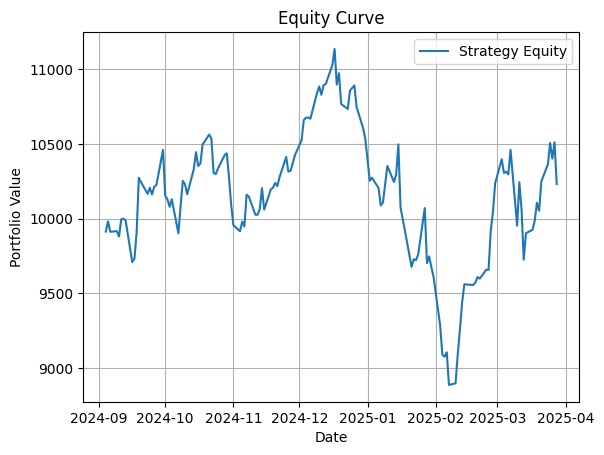

In [207]:

aapl['strategy_returns']=aapl['signal'].shift(1)*aapl['daily_returns']
aapl['equity']=10000 * (1 + aapl['strategy_returns']).cumprod()

plt.plot(aapl['Date'],aapl['equity'], label='Strategy Equity')
plt.title("Equity Curve")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.show()

In [208]:
print(df['signal'].value_counts())


signal
 1    180
-1     29
 0      2
Name: count, dtype: int64


In [222]:
sharpe_ratio=aapl['strategy_returns'].mean()/aapl['strategy_returns'].std()* np.sqrt(252)
print(sharpe_ratio)

0.2901604185213151


In [224]:
print(aapl['equity'])

0               NaN
1       9913.812705
2       9982.493506
3       9912.465470
4       9916.505800
           ...     
138    10364.244988
139    10506.047629
140    10401.808411
141    10510.743057
142    10231.364019
Name: equity, Length: 143, dtype: float64


In [226]:
aapl.loc[aapl.index[0], 'equity'] = 10000

aapl['rolling_max'] = aapl['equity'].cummax()
aapl['drawdown'] = aapl['equity'] / aapl['rolling_max'] - 1
max_drawdown = aapl['drawdown'].min()
print(f"Max Drawdown: {max_drawdown:.2%}")


Max Drawdown: -20.18%


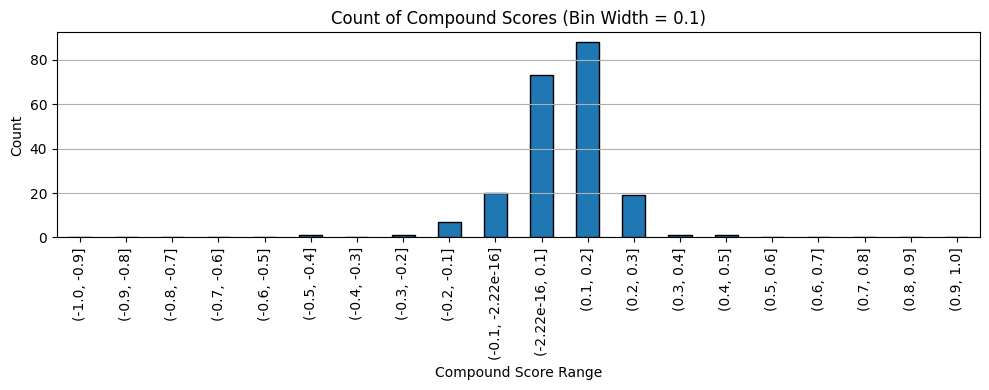

In [209]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define smaller bins: -1 to 1 in steps of 0.1
bins = np.arange(-1.0, 1.01, 0.1)
df['compound_bin'] = pd.cut(df['compound'], bins)

# Count how many scores fall into each bin
counts = df['compound_bin'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 4))
counts.plot(kind='bar', edgecolor='black')
plt.title('Count of Compound Scores (Bin Width = 0.1)')
plt.xlabel('Compound Score Range')
plt.ylabel('Count')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


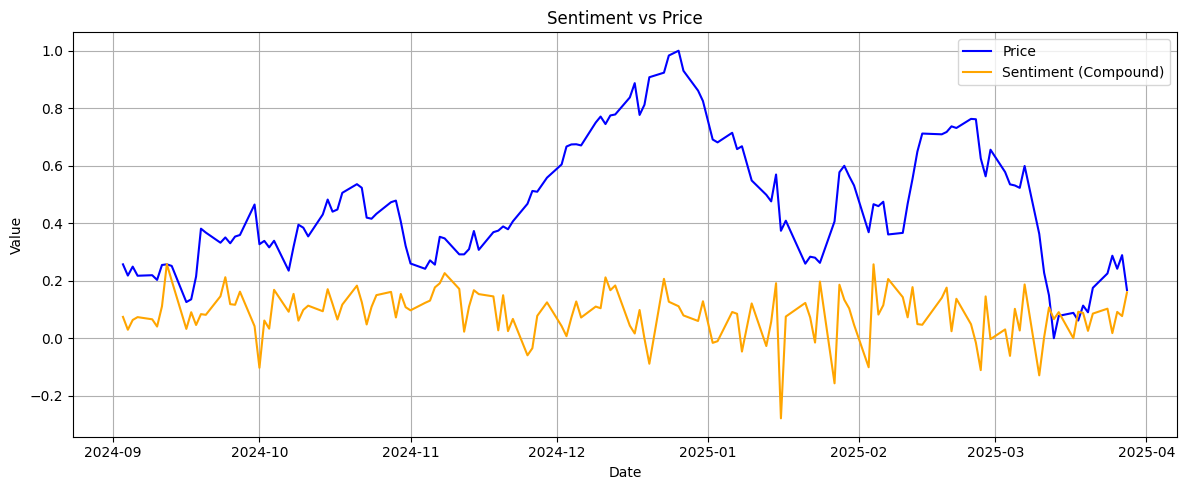

-0.02940986237906132


In [218]:
aapl['normalized_price'] = (aapl['Close'] - aapl['Close'].min()) / (aapl['Close'].max() - aapl['Close'].min())

plt.figure(figsize=(12, 5))
plt.plot(aapl['date'], aapl['normalized_price'], label='Price', color='blue')
plt.plot(aapl['date'], aapl['compound'], label='Sentiment (Compound)', color='orange')
plt.title('Sentiment vs Price')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(aapl['normalized_price'].corr(aapl['compound']))
